In [19]:
import pandas as pd
import numpy as np

from copy import deepcopy
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

# # import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# 1. LOAD DATA

In [3]:
application_train = pd.read_csv(r'../data/features/application_fe_train.csv')
print(application_train.shape)

application_test = pd.read_csv(r'../data/features/application_fe_test.csv')
print(application_test.shape)

(307511, 104)
(48744, 103)


In [4]:
bureau_fe_train = pd.read_csv(r'../data/features/bureau_fe_train.csv')
bureau_fe_train.drop(columns = 'TARGET', inplace=True)
bureau_fe_test = pd.read_csv(r'../data/features/bureau_fe_test.csv')

In [5]:
print(bureau_fe_train.shape)
print(bureau_fe_test.shape)

(307511, 145)
(48744, 145)


In [6]:
application_bur_train = application_train.merge(bureau_fe_train, on='SK_ID_CURR', how='left')
application_bur_test = application_test.merge(bureau_fe_test, on='SK_ID_CURR', how='left')

print(application_bur_train.shape)
print(application_bur_test.shape)

(307511, 248)
(48744, 247)


In [7]:
prev_cc_pos_fe = pd.read_csv(r'../data/features/feature_prev_cc_pos_install_fe.csv')

In [8]:
application_full_train = application_bur_train.merge(prev_cc_pos_fe, on='SK_ID_CURR', how='left')
application_full_test = application_bur_test.merge(prev_cc_pos_fe, on='SK_ID_CURR', how='left')

print(application_full_train.shape)
print(application_full_test.shape)

(307511, 748)
(48744, 747)


In [9]:
application_full_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OCCUPATION_RISK,ORG_RISK,FONDKAPREMONT_MODE_IS_NA,HOUSETYPE_MODE_IS_NA,WALLSMATERIAL_MODE_IS_NA,EMERGENCYSTATE_MODE_IS_NA,AGE_BIN,CAR_AGE_BIN,EXT_SOURCE_1_MM,EXT_SOURCE_2_MM,EXT_SOURCE_3_MM,EXT_MEAN,EXT_MIN,EXT_MAX,EXT_STD,EXT_PROD,EXT_WEIGHTED,CREDIT_TO_INCOME_RATIO,CREDIT_TO_ANNUITY_RATIO,ANNUITY_TO_INCOME_RATIO,PAYMENT_RATE,GOODS_TO_INCOME_RATIO,GOODS_TO_CREDIT_RATIO,CREDIT_BURDEN,ANNUITY_CREDIT_RATIO,INCOME_PER_FAMILY,INCOME_PER_CHILD,CREDIT_PER_FAMILY,INCOME_HOUSING_RATIO,DOC_COUNT,...,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM,INS_LATE_PAYMENT_MEAN,INS_LATE_PAYMENT_SUM,INS_LATE_PAYMENT_RATIO_MEAN,INS_PAID_OVER_MEAN,INS_PAYMENT_DIFFERENCE_MEAN,INS_PAYMENT_RATIO_MEAN,INS_SIGNIFICANT_LATE_PAYMENT_MEAN,INS_SIGNIFICANT_LATE_PAYMENT_SUM,INS_24M_SK_ID_PREV_SIZE,INS_24M_AMT_INSTALMENT_MIN,INS_24M_AMT_INSTALMENT_MAX,INS_24M_AMT_INSTALMENT_MEAN,INS_24M_AMT_INSTALMENT_SUM,INS_24M_AMT_PAYMENT_MIN,INS_24M_AMT_PAYMENT_MAX,INS_24M_AMT_PAYMENT_MEAN,INS_24M_AMT_PAYMENT_SUM,INS_24M_DAYS_ENTRY_PAYMENT_MIN,INS_24M_DAYS_ENTRY_PAYMENT_MAX,INS_24M_DAYS_ENTRY_PAYMENT_MEAN,INS_24M_DPD_MAX,INS_24M_DPD_MEAN,INS_24M_DPD_VAR,INS_24M_DBD_MAX,INS_24M_DBD_MEAN,INS_24M_DBD_VAR,INS_24M_DPD_7_MEAN,INS_24M_DPD_15_MEAN,INS_24M_LATE_PAYMENT_MEAN,INS_24M_LATE_PAYMENT_RATIO_MEAN,INS_24M_PAYMENT_DIFFERENCE_MEAN,INS_24M_PAYMENT_RATIO_MEAN,INS_24M_SIGNIFICANT_LATE_PAYMENT_MEAN,INS_60M_SK_ID_PREV_SIZE,INS_60M_AMT_INSTALMENT_MIN,INS_60M_AMT_INSTALMENT_MAX,INS_60M_AMT_INSTALMENT_MEAN,INS_60M_AMT_INSTALMENT_SUM,INS_60M_AMT_PAYMENT_MIN,INS_60M_AMT_PAYMENT_MAX,INS_60M_AMT_PAYMENT_MEAN,INS_60M_AMT_PAYMENT_SUM,INS_60M_DAYS_ENTRY_PAYMENT_MIN,INS_60M_DAYS_ENTRY_PAYMENT_MAX,INS_60M_DAYS_ENTRY_PAYMENT_MEAN,INS_60M_DPD_MAX,INS_60M_DPD_MEAN,INS_60M_DPD_VAR,INS_60M_DBD_MAX,INS_60M_DBD_MEAN,INS_60M_DBD_VAR,INS_60M_DPD_7_MEAN,INS_60M_DPD_15_MEAN,INS_60M_LATE_PAYMENT_MEAN,INS_60M_LATE_PAYMENT_RATIO_MEAN,INS_60M_PAYMENT_DIFFERENCE_MEAN,INS_60M_PAYMENT_RATIO_MEAN,INS_60M_SIGNIFICANT_LATE_PAYMENT_MEAN,LAST_LOAN_DPD_sum,LAST_LOAN_DPD_mean,LAST_LOAN_DPD_max,LAST_LOAN_DPD_std,LAST_LOAN_LATE_PAYMENT_count,LAST_LOAN_LATE_PAYMENT_mean,LAST_LOAN_PAID_OVER_AMOUNT_sum,LAST_LOAN_PAID_OVER_AMOUNT_mean,LAST_LOAN_PAID_OVER_AMOUNT_max,LAST_LOAN_PAID_OVER_AMOUNT_min,LAST_LOAN_PAID_OVER_AMOUNT_std,LAST_LOAN_PAID_OVER_count,LAST_LOAN_PAID_OVER_mean
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,9.0,1.0,0.0,1.0,1.0,2.0,10.0,0.0,0.083037,0.262949,0.139376,2.0,-1134.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.036202,0.250941,0.056221,-0.015113,0.012820,0.188660,0.111466,0.213833,-0.037978,-0.010771,0.154966,0,0,0,0,1,2,0,0,0,0,1,2,0.072215,0.307542,0.155054,0.178271,0.072215,0.307542,0.119369,0.003444,0.917136,2.007889,16.461104,0.121978,0.060749,1.733333,0.863262,406597.50,0.060749,202500.0,202500.0,406597.50,0.576923,1.0,...,0.000000,0.0,0.0,0.0,1.000000,19.0,1.000000,0.0,0.000000e+00,1.0,1.000000,19.0,19.0,9251.775,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-587.0,-49.0,-315.421053,0.0,0.0,0.0,31.0,20.421053,24.257310,0.0,0.0,1.000000,1.000000,0.0,1.0,1.000000,19.0,9251

In [10]:
application_full_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 748 columns):
 #    Column                                                        Dtype  
---   ------                                                        -----  
 0    CNT_CHILDREN                                                  float64
 1    AMT_INCOME_TOTAL                                              float64
 2    AMT_CREDIT                                                    float64
 3    AMT_ANNUITY                                                   float64
 4    AMT_GOODS_PRICE                                               float64
 5    REGION_POPULATION_RELATIVE                                    float64
 6    DAYS_BIRTH                                                    float64
 7    DAYS_EMPLOYED                                                 float64
 8    DAYS_REGISTRATION                                             float64
 9    DAYS_ID_PUBLISH                               

## 1.1 Reduce memory

In [11]:
def reduce_memory_usage(df, verbose=True):
    import numpy as np
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            # Integer
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)

            # Float
            else:
                # Float16 có thể gây mất precision → nên dùng cho FE lớn như Home Credit
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)  # float16 dễ lỗi → float32 là an toàn nhất
                else:
                    df[col] = df[col].astype(np.float32)
        
        # Object → Category (chỉ nếu unique < 50% size)
        else:
            num_unique = df[col].nunique()
            num_total = len(df[col])
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'Memory giảm từ {start_mem:.2f} MB xuống {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% giảm)')

    return df


In [12]:
application_full_train = reduce_memory_usage(application_full_train)
application_full_test  = reduce_memory_usage(application_full_test)

Memory giảm từ 1754.90 MB xuống 866.01 MB (50.7% giảm)
Memory giảm từ 277.80 MB xuống 137.23 MB (50.6% giảm)


In [30]:
# làm sạch tên cột để tránh lỗi LightGBM
def clean_column_name(col):
    return (col.replace(" ", "_")
               .replace(":", "_")
               .replace(",", "_")
               .replace(";", "_")
               .replace("/", "_")
               .replace("\\", "_")
               .replace("[", "_")
               .replace("]", "_")
               .replace("{", "_")
               .replace("}", "_")
               .replace("(", "_")
               .replace(")", "_")
               .replace("\n", "_")
               .replace("\t", "_")
               .replace("'", "_")
               .replace('"', "_")
               .strip()
               )

In [31]:
application_full_train.columns = [clean_column_name(c) for c in application_full_train.columns]
application_full_test.columns  = [clean_column_name(c) for c in application_full_test.columns]

features = application_full_train.columns.tolist()

In [32]:
features

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 

# 2. MODEL

## 2.1 BaggingClassifier (Downsampling)

In [40]:
def train_bagging_downsample(base_model, X, y, n_estimators=3,
                             eval_set=None, early_stopping_rounds=100, verbose=100):

    from copy import deepcopy
    from sklearn.model_selection import KFold
    import pandas as pd
    import numpy as np
    import lightgbm as lgb

    models = []

    minority_class = y.value_counts().idxmin()
    majority_class = y.value_counts().idxmax()

    X_min = X[y == minority_class]
    y_min = y[y == minority_class]

    X_maj = X[y == majority_class]
    y_maj = y[y == majority_class]

    kf = KFold(n_splits=n_estimators, shuffle=True, random_state=42)

    for bag_i, (_, idx_sub) in enumerate(kf.split(X_maj), 1):

        print(f"\n=== Bagging round {bag_i}/{n_estimators} ===")

        X_maj_sub = X_maj.iloc[idx_sub]
        y_maj_sub = y_maj.iloc[idx_sub]

        X_sub = pd.concat([X_min, X_maj_sub])
        y_sub = pd.concat([y_min, y_maj_sub])

        model = deepcopy(base_model)

        model.fit(
            X_sub, y_sub,
            eval_set=eval_set,
            callbacks=[
                lgb.early_stopping(early_stopping_rounds),
                lgb.log_evaluation(verbose)
            ]
        )

        models.append(model)

    return models


def bagging_predict_proba(models, X):
    import numpy as np
    preds = np.zeros((len(X), 2))

    for model in models:
        preds += model.predict_proba(X)

    return preds / len(models)

## 2.2 Trainning model

In [41]:
train_df = application_full_train.copy()
test_df  = application_full_test.copy()

y = train_df["TARGET"]

remove_cols = ["SK_ID_CURR", "TARGET"]
features = [col for col in train_df.columns if col not in remove_cols]

X = train_df[features]
X_test = test_df[features]

print("Train:", X.shape)
print("Test :", X_test.shape)

Train: (307511, 746)
Test : (48744, 746)


In [42]:
# LIGHTGBM PARAMETERS


lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 26,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "verbosity": -1,
    "seed": 42,
}

In [43]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

valid_indices_per_fold = []
feature_importance_df = pd.DataFrame()

for fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    print(f"\n================ FOLD {fold+1}/5 ================")
    
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    valid_indices_per_fold.append(valid_idx)

    base_model = lgb.LGBMClassifier(
        **lgb_params,
        n_estimators=5000
    )

    # Train 3 models by bagging downsampling
    models = train_bagging_downsample(
        base_model=base_model,
        X=X_train,
        y=y_train,
        n_estimators=3,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=200,
        verbose=200
    )

    # Predict valid
    oof_preds[valid_idx] = bagging_predict_proba(models, X_valid)[:, 1]

    # Predict test
    test_preds += bagging_predict_proba(models, X_test)[:, 1] / 5


    # ======================================
    # FEATURE IMPORTANCE (GAIN + SPLIT)
    # ======================================

    # Dùng model đầu tiên đại diện (models[0])
    booster = models[0].booster_

    fold_split = pd.DataFrame({
        "feature": X.columns,
        "importance": booster.feature_importance(importance_type="split"),
        "fold": fold + 1,
        "type": "split"
    })

    fold_gain = pd.DataFrame({
        "feature": X.columns,
        "importance": booster.feature_importance(importance_type="gain"),
        "fold": fold + 1,
        "type": "gain"
    })

    # Append vào bảng chung
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_split, fold_gain],
        axis=0
    )

    auc = roc_auc_score(y_valid, oof_preds[valid_idx])
    print(f"Fold {fold+1} AUC = {auc:.6f}")


================ FOLD 1/5 ================

=== Bagging round 1/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.782678
[400]	valid_0's auc: 0.787956
[600]	valid_0's auc: 0.789217
[800]	valid_0's auc: 0.789989
[1000]	valid_0's auc: 0.790339
[1200]	valid_0's auc: 0.790334
Early stopping, best iteration is:
[1076]	valid_0's auc: 0.790565

=== Bagging round 2/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.783009
[400]	valid_0's auc: 0.787812
[600]	valid_0's auc: 0.78957
[800]	valid_0's auc: 0.789949
[1000]	valid_0's auc: 0.790361
[1200]	valid_0's auc: 0.790384
Early stopping, best iteration is:
[1078]	valid_0's auc: 0.790491

=== Bagging round 3/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.783133
[400]	valid_0's auc: 0.788354
[600]	valid_0's auc: 0.789895
[800]	valid_0's auc: 0.79041
[1000]	valid_0's auc: 0.790885
[1200]	valid_0's auc: 0.791021
[1400]	valid_

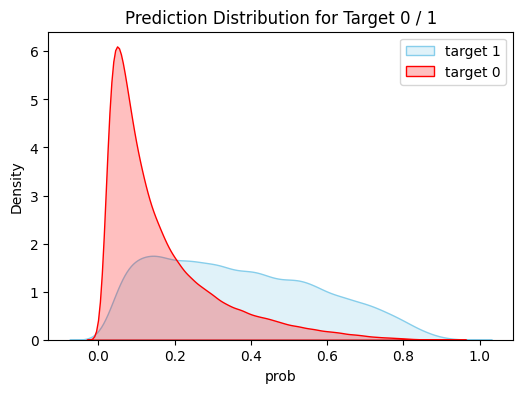

C:\Users\Admin\AppData\Local\Temp\ipykernel_19168\1659469839.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_19168\1659469839.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


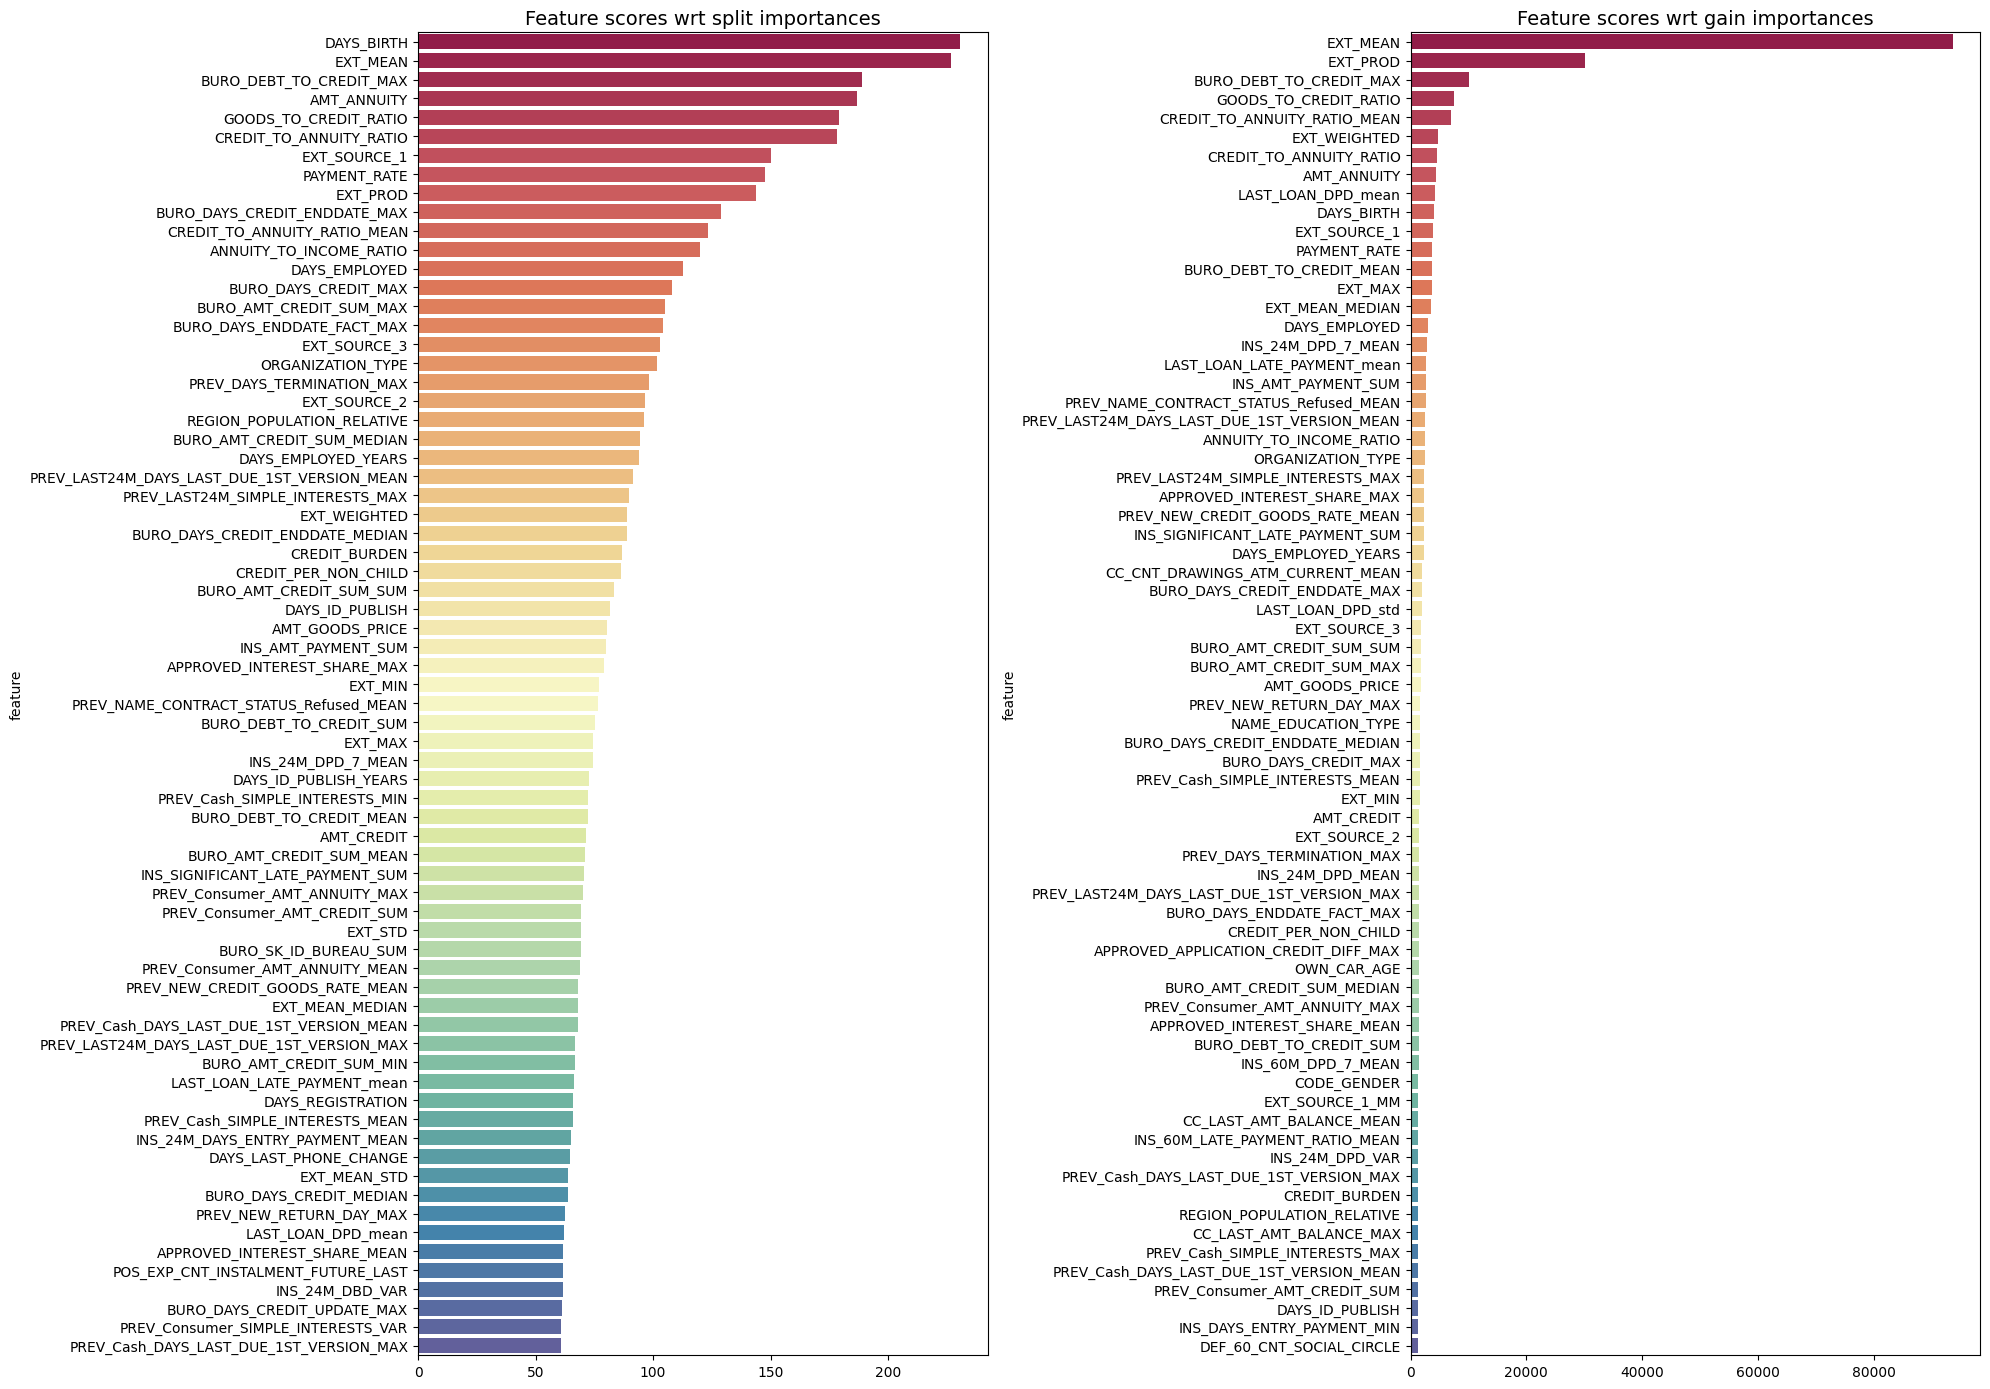

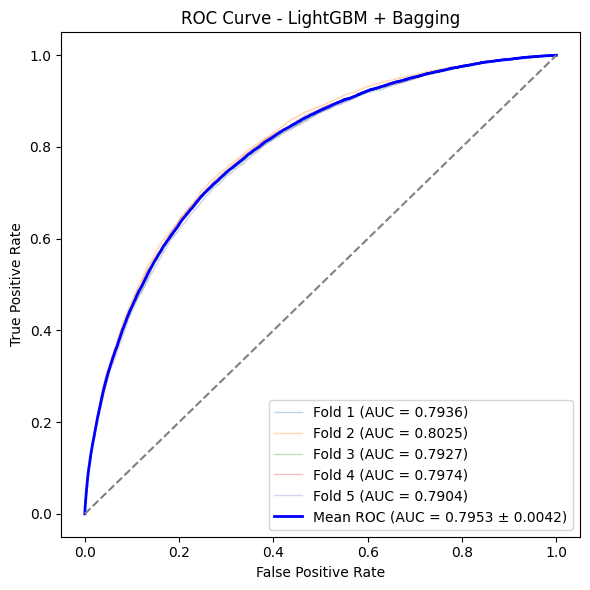

In [47]:
# ====================================
# 1) Prediction Distribution
# ====================================

prob_df = pd.DataFrame({
    'SK_ID_CURR': train_df['SK_ID_CURR'],
    'prob': oof_preds,
    'target': y
})

plt.figure(figsize=(6,4))
sns.kdeplot(prob_df.loc[prob_df['target']==1, 'prob'],     # type: ignore
            color="skyblue", fill=True, label="target 1")  # type: ignore
sns.kdeplot(prob_df.loc[prob_df['target']==0, 'prob'],     # type: ignore
            color="red", fill=True, label="target 0")      # type: ignore

plt.legend()
plt.title("Prediction Distribution for Target 0 / 1")
plt.show()


# ====================================
# Feature Importance: Gain + Split
# ====================================

# 1) Tính trung bình importance theo từng loại
mean_gain = (
    feature_importance_df[feature_importance_df["type"] == "gain"]
    .groupby("feature")["importance"]
    .mean()
)

mean_split = (
    feature_importance_df[feature_importance_df["type"] == "split"]
    .groupby("feature")["importance"]
    .mean()
)

# 2) Chọn top 30 features cho mỗi loại
top_gain = mean_gain.sort_values(ascending=False).iloc[:70]
top_split = mean_split.sort_values(ascending=False).iloc[:70]

# ============ PLOT ================
fig, axes = plt.subplots(1, 2, figsize=(20, 14))

# Left chart — Split importance
sns.barplot(
    x=top_split.values,
    y=top_split.index,
    ax=axes[0],
    palette="Spectral"
)
axes[0].set_title("Feature scores wrt split importances", fontsize=14)

# Right chart — Gain importance
sns.barplot(
    x=top_gain.values,
    y=top_gain.index,
    ax=axes[1],
    palette="Spectral"
)
axes[1].set_title("Feature scores wrt gain importances", fontsize=14)

plt.tight_layout()
plt.show()



# ====================================
# 3) ROC CURVE
# ====================================

plt.figure(figsize=(6,6))
fold_auc_list = []

for fold, valid_idx in enumerate(valid_indices_per_fold):
    fpr, tpr, _ = roc_curve(y.iloc[valid_idx], oof_preds[valid_idx])
    auc = roc_auc_score(y.iloc[valid_idx], oof_preds[valid_idx])
    fold_auc_list.append(auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {fold+1} (AUC = {auc:.4f})")

# Overall ROC
fpr, tpr, _ = roc_curve(y, oof_preds)
auc = roc_auc_score(y, oof_preds)

plt.plot(fpr, tpr, color='blue', lw=2,
         label=f"Mean ROC (AUC = {auc:.4f} ± {np.std(fold_auc_list):.4f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM + Bagging")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
# Save train predictions
train_out = pd.DataFrame({
    "SK_ID_CURR": train_df["SK_ID_CURR"],
    "TARGET": y,
    "PRED": oof_preds
})
# Save Out-Of-Fold 
train_out.to_csv("oof_lgbm_bagging.csv", index=False)

# Save submission file
submission = pd.DataFrame({
    "SK_ID_CURR": test_df["SK_ID_CURR"],
    "TARGET": test_preds
})
submission.to_csv("../sub_files/submission_lgbm_bagging.csv", index=False)

print("Saved:")
print(" - lgbm_bagging.csv")
print(" - submission_lgbm_bagging.csv")


Saved:
 - lgbm_bagging.csv
 - submission_lgbm_bagging.csv


## 2.3 Reduce number of features

In [ ]:
# Compute mean importance across folds
mean_importance = (
    feature_importance_df
    .groupby("feature")["importance"]
    .mean()
    .sort_values(ascending=False)
)

# Select top 300 unique features
top300_fe = mean_importance.index[:300].tolist()

print("Number of selected features:", len(top300_fe))

Number of selected features: 300


In [68]:
# ============================
# 2) Create new X and X_test
# ============================

X_selected = X[top300_fe].copy()
X_test_selected = X_test[top300_fe].copy()


# ============================
# 3) Re-run training loop
# ============================

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_selected))
test_preds = np.zeros(len(X_test_selected))

feature_importance_df_new = pd.DataFrame()

valid_indices_per_fold = []

for fold, (train_idx, valid_idx) in enumerate(folds.split(X_selected, y)):
    
    print(f"\n================ FOLD {fold+1}/5 ================")
    
    X_train, X_valid = X_selected.iloc[train_idx], X_selected.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    valid_indices_per_fold.append(valid_idx)

    base_model = lgb.LGBMClassifier(
        **lgb_params,
        n_estimators=5000
    )

    # Train bagging downsampling
    models = train_bagging_downsample(
        base_model=base_model,
        X=X_train,
        y=y_train,
        n_estimators=3,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=200,
        verbose=200
    )

    # Predict validation
    oof_preds[valid_idx] = bagging_predict_proba(models, X_valid)[:, 1]

    # Predict test
    test_preds += bagging_predict_proba(models, X_test_selected)[:, 1] / 5

    # Save feature importance
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_selected.columns
    fold_importance["importance"] = models[0].feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importance_df_new = pd.concat([feature_importance_df_new, fold_importance], axis=0)

    auc = roc_auc_score(y_valid, oof_preds[valid_idx])
    print(f"Fold {fold+1} AUC = {auc:.6f}")

# Print final AUC
print("\nFinal OOF AUC:", roc_auc_score(y, oof_preds))


================ FOLD 1/5 ================

=== Bagging round 1/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.783005
[400]	valid_0's auc: 0.788856
[600]	valid_0's auc: 0.790026
[800]	valid_0's auc: 0.790585
[1000]	valid_0's auc: 0.790933
[1200]	valid_0's auc: 0.790887
Early stopping, best iteration is:
[1120]	valid_0's auc: 0.791333

=== Bagging round 2/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.782714
[400]	valid_0's auc: 0.788457
[600]	valid_0's auc: 0.78977
[800]	valid_0's auc: 0.790303
[1000]	valid_0's auc: 0.790865
[1200]	valid_0's auc: 0.790791
Early stopping, best iteration is:
[1035]	valid_0's auc: 0.791043

=== Bagging round 3/3 ===
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.782788
[400]	valid_0's auc: 0.788282
[600]	valid_0's auc: 0.789974
[800]	valid_0's auc: 0.790541
[1000]	valid_0's auc: 0.7906
Early stopping, best iteration is:
[824]	vali

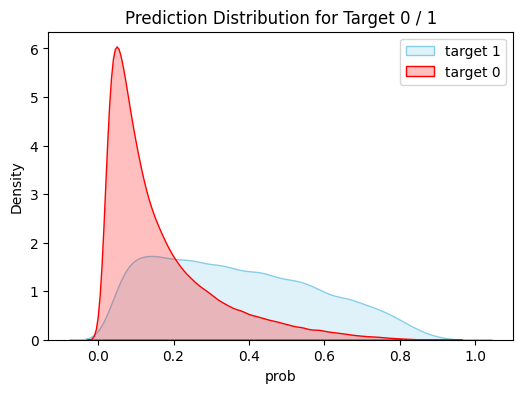

C:\Users\Admin\AppData\Local\Temp\ipykernel_19168\1659469839.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Admin\AppData\Local\Temp\ipykernel_19168\1659469839.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


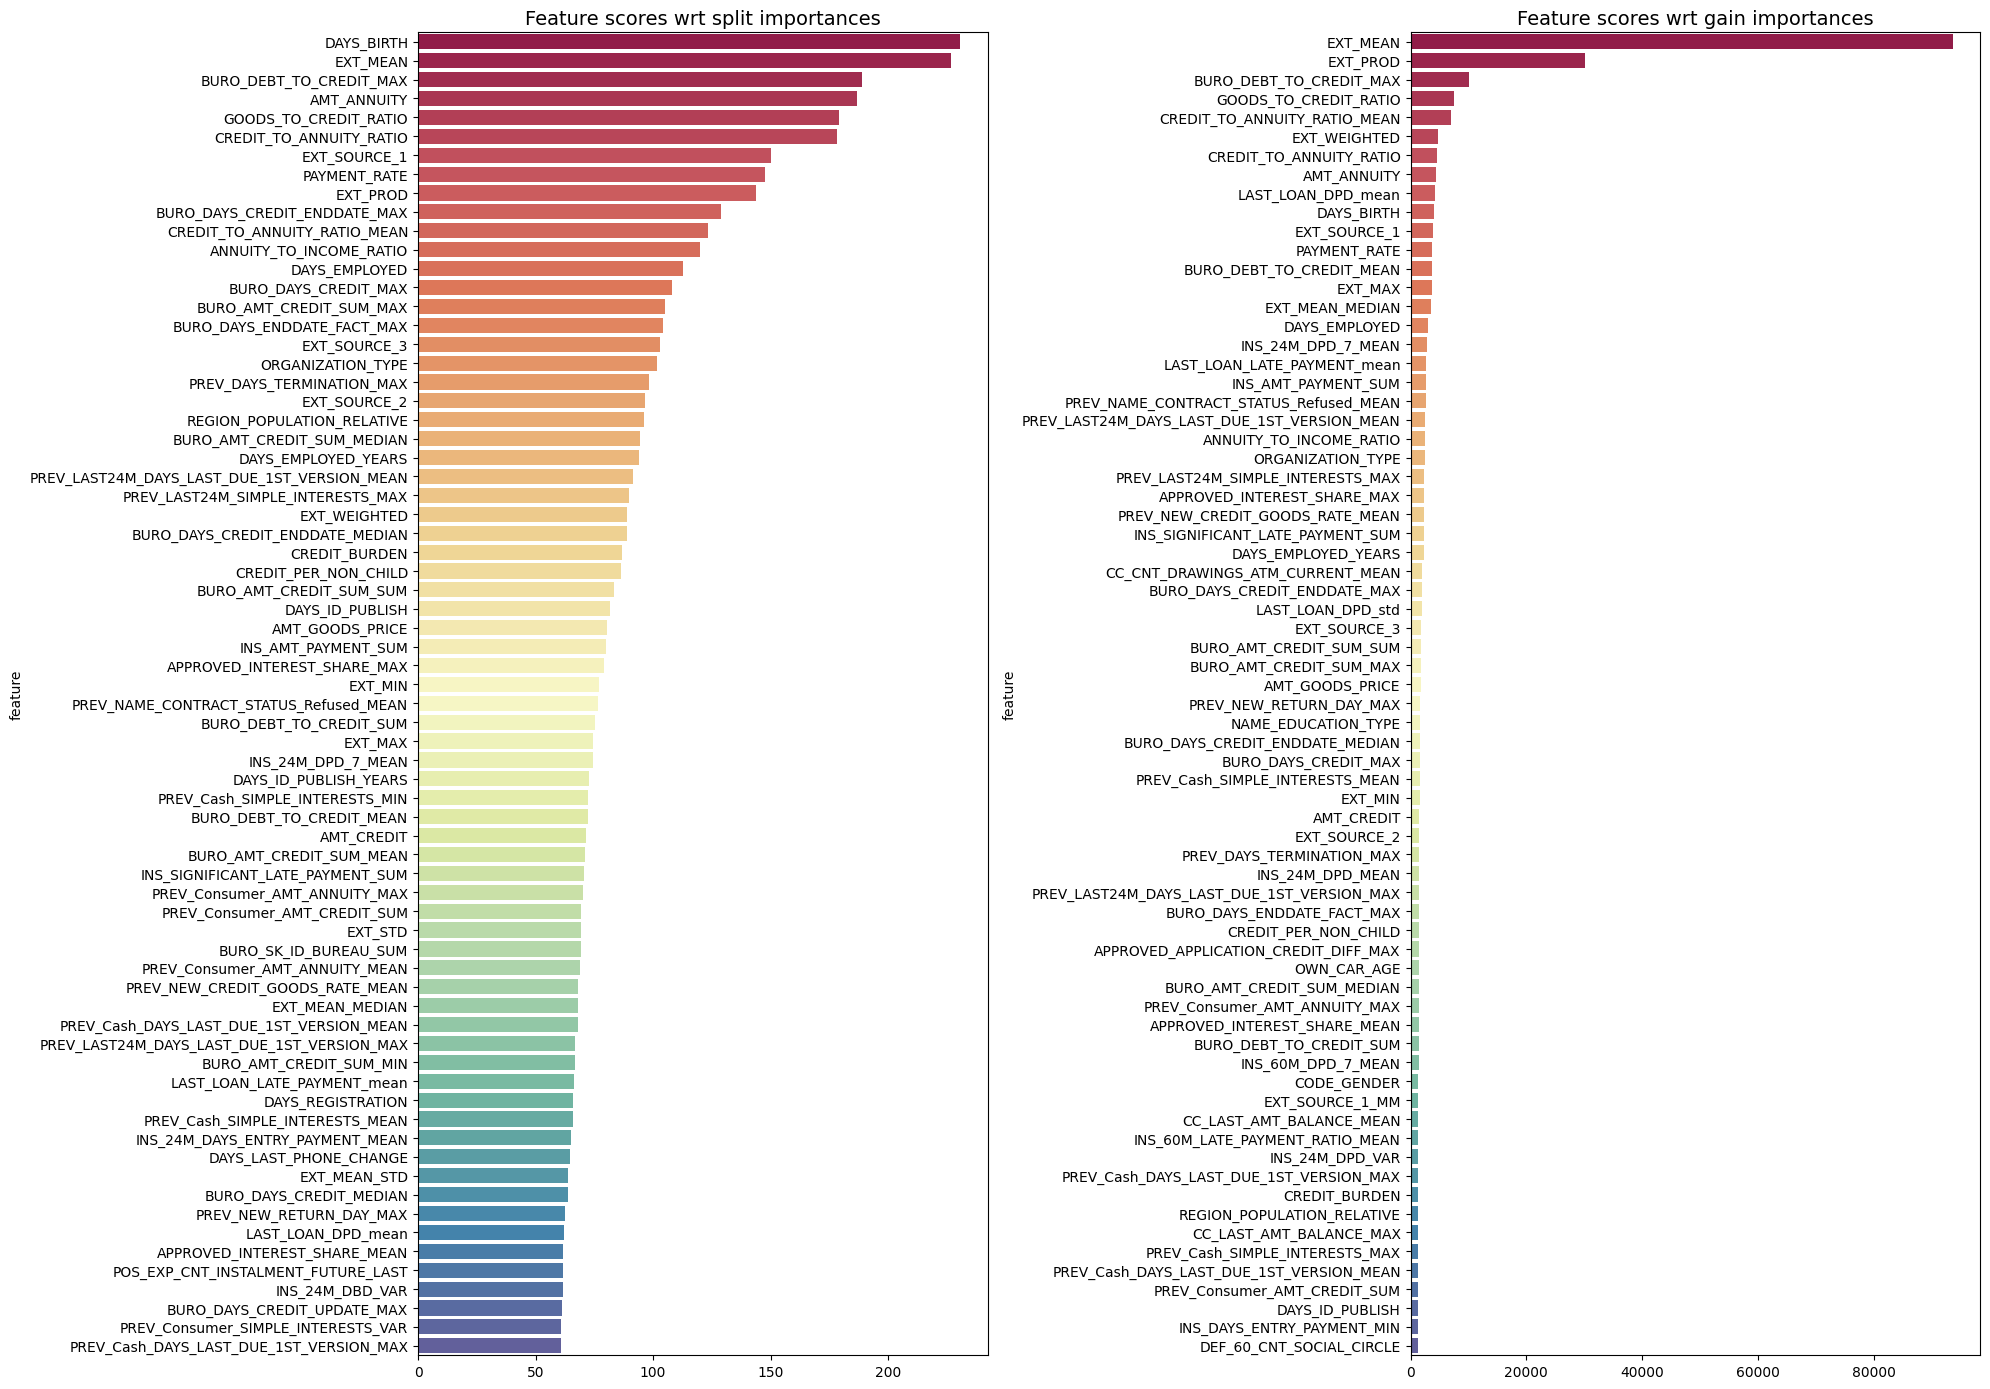

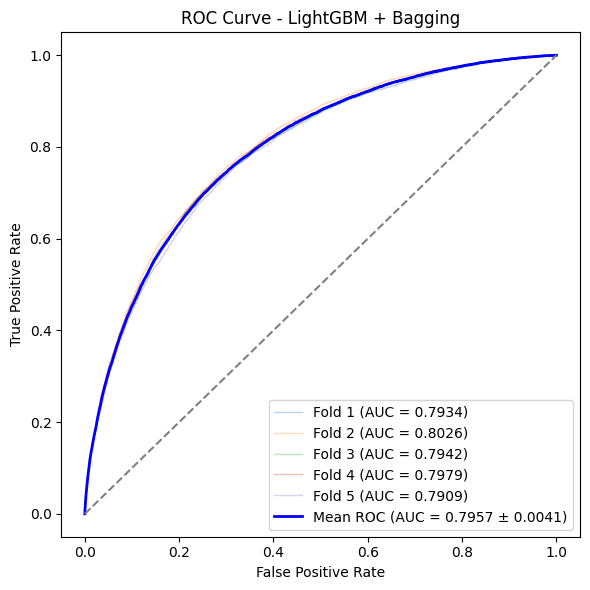

In [69]:
# ====================================
# 1) Prediction Distribution
# ====================================

prob_df = pd.DataFrame({
    'SK_ID_CURR': train_df['SK_ID_CURR'],
    'prob': oof_preds,
    'target': y
})

plt.figure(figsize=(6,4))
sns.kdeplot(prob_df.loc[prob_df['target']==1, 'prob'],     # type: ignore
            color="skyblue", fill=True, label="target 1")  # type: ignore
sns.kdeplot(prob_df.loc[prob_df['target']==0, 'prob'],     # type: ignore
            color="red", fill=True, label="target 0")      # type: ignore

plt.legend()
plt.title("Prediction Distribution for Target 0 / 1")
plt.show()


# ====================================
# Feature Importance: Gain + Split
# ====================================

# 1) Tính trung bình importance theo từng loại
mean_gain = (
    feature_importance_df[feature_importance_df["type"] == "gain"]
    .groupby("feature")["importance"]
    .mean()
)

mean_split = (
    feature_importance_df[feature_importance_df["type"] == "split"]
    .groupby("feature")["importance"]
    .mean()
)

# 2) Chọn top 30 features cho mỗi loại
top_gain = mean_gain.sort_values(ascending=False).iloc[:70]
top_split = mean_split.sort_values(ascending=False).iloc[:70]

# ============ PLOT ================
fig, axes = plt.subplots(1, 2, figsize=(20, 14))

# Left chart — Split importance
sns.barplot(
    x=top_split.values,
    y=top_split.index,
    ax=axes[0],
    palette="Spectral"
)
axes[0].set_title("Feature scores wrt split importances", fontsize=14)

# Right chart — Gain importance
sns.barplot(
    x=top_gain.values,
    y=top_gain.index,
    ax=axes[1],
    palette="Spectral"
)
axes[1].set_title("Feature scores wrt gain importances", fontsize=14)

plt.tight_layout()
plt.show()



# ====================================
# 3) ROC CURVE
# ====================================

plt.figure(figsize=(6,6))
fold_auc_list = []

for fold, valid_idx in enumerate(valid_indices_per_fold):
    fpr, tpr, _ = roc_curve(y.iloc[valid_idx], oof_preds[valid_idx])
    auc = roc_auc_score(y.iloc[valid_idx], oof_preds[valid_idx])
    fold_auc_list.append(auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"Fold {fold+1} (AUC = {auc:.4f})")

# Overall ROC
fpr, tpr, _ = roc_curve(y, oof_preds)
auc = roc_auc_score(y, oof_preds)

plt.plot(fpr, tpr, color='blue', lw=2,
         label=f"Mean ROC (AUC = {auc:.4f} ± {np.std(fold_auc_list):.4f})")

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM + Bagging")
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
# Save submission file
submission = pd.DataFrame({
    "SK_ID_CURR": test_df["SK_ID_CURR"],
    "TARGET": test_preds
})
submission.to_csv("../sub_files/submission_lgbm_bagging_t300.csv", index=False)

print("Saved:")
print(" - submission_lgbm_bagging_t300.csv")

Saved:
 - submission_lgbm_bagging_t300.csv
